# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y Arboles de decision:**

Se selccionan las variables explicativas y la respuesta.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)


from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [4]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [5]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [7]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento:

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [9]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


## **4.1.1 Arbol de decision sin tecnicas de balanceo**

Iniciaremos corriendo nuestro modelo de Arbol de Desición en crudo, sin hacer uso de ninguna tecnica de balanceo.

In [ ]:
# ========================
# 5️⃣ Modelo sin SMOTE
# ========================

modelo = DecisionTreeClassifier( 
    criterion="gini",
    max_depth=None,
    random_state=42 )

pipeline_sin_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo)
])


In [11]:
pipeline_sin_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

Una vez que nuestro modelo corrió, haremos uso de la función que creamos, llamada “evaluar modelo”, para así analizar el rendimiento de nuestro modelo en bruto.

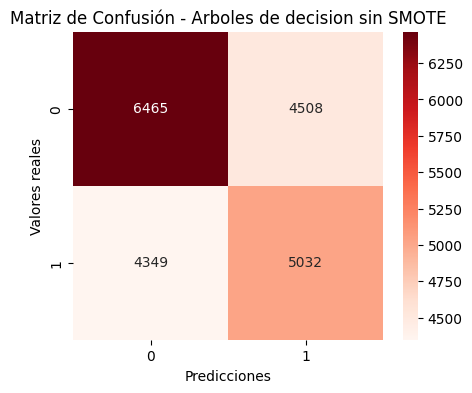

Modelo: Arboles de decision sin SMOTE
Accuracy: 0.565
Precision: 0.527
Recall: 0.536
F1-score: 0.532
AUC: 0.563

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.59      0.59     10973
           1       0.53      0.54      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.57      0.56      0.57     20354



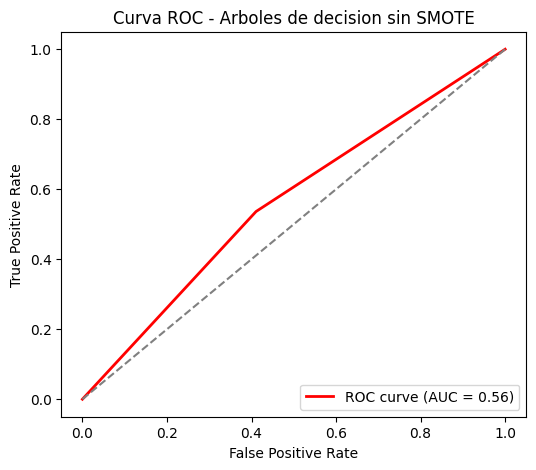

In [12]:
result_sin = evaluar_modelo(pipeline_sin_smote, X_test, y_test, nombre_modelo="Arboles de decision sin SMOTE")

### **Análisis Matriz de Confusión:**

La matriz de confusión, que nos muestra cómo el modelo clasifica correcta o incorrectamente los registros con respecto a las clases reales, evidencia que el modelo de **árboles de decisión** acierta al clasificar la clase 0 en el **31.77 % de los casos (equivalente a 6,465 observaciones)**. Sin embargo, se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.14 % de los casos (4,508 observaciones)**.

Por otro lado, al clasificar la clase 1, el modelo lo hace correctamente el **24.71 % de las veces (5,032 observaciones)** y se equivoca en el **21.38 % de los casos (4,349 observaciones)**.

En general, esto indica que el modelo tiene un desempeño moderado, con un número similar de errores en ambas clases, lo que sugiere cierto desequilibrio en la clasificación o la necesidad de ajustar los hiperparámetros para mejorar su capacidad predictiva.

### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 56.5% de las predicciones totales. Es un desempeño moderado.

**Precision:** De todas las predicciones positivas (clase 1), el 52.7% fueron realmente positivas. Lo cual indica que hay bastantes falsos positivos.

**Recall:** De todos los casos que realmente eran positivos, el modelo detectó correctamente el 53.6 %. Muestra que hay una proporción considerable de falsos negativos.

**F1-score:** Un valor de 0.532 indica un rendimiento medio-bajo en la identificación de la clase positiva.

**AUC:** Representa la capacidad del modelo para distinguir entre clases. Un valor de 0.563 indica que el modelo apenas supera el azar (0.5 sería equivalente a adivinar).

### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
| ----------- | --------- | ------ | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Clase 0** | 0.60      | 0.59   | 0.59     | El modelo identifica correctamente la clase 0 en un **59 %** de los casos. Tiene un desempeño **ligeramente mejor** en esta clase, probablemente porque es la clase **mayoritaria**. |
| **Clase 1** | 0.53      | 0.54   | 0.53     | La capacidad del modelo para reconocer la clase 1 (minoritaria) es más débil. Indica que **confunde muchos casos positivos**.                                                        |

El modelo de árboles de decisión sin SMOTE presenta un desempeño moderado, con una exactitud del 56.5 % y métricas de precisión, recall y F1-score cercanas al 0.53. Esto indica que el modelo tiene dificultades para distinguir correctamente entre pacientes que reingresarán y los que no.

### **Curva ROC:**

La curva ROC muestra que el modelo de árboles de decisión sin SMOTE tiene un AUC de 0.56, lo que indica una capacidad muy limitada para distinguir entre pacientes que reingresarán y los que no. Su desempeño es apenas superior al azar, evidenciando la necesidad de aplicar técnicas de balanceo y ajuste del modelo para mejorar su sensibilidad y poder predictivo.


## **4.1.2 Arbol de decision con SMOTE**

Ahora procederemos a aplicar tecnicas de balanceo, iniciaremos con las tecnica SMOTE:

In [13]:
# ========================
# 6️⃣ Modelo con SMOTE
# ========================
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_con_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", modelo)
])

In [14]:
pipeline_con_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', DecisionTreeClassifier(random_state=42))])

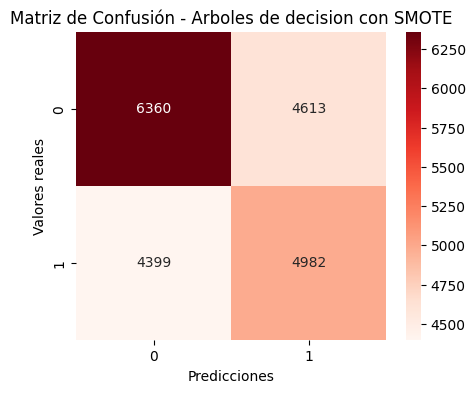

Modelo: Arboles de decision con SMOTE
Accuracy: 0.557
Precision: 0.519
Recall: 0.531
F1-score: 0.525
AUC: 0.555

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.58      0.59     10973
           1       0.52      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



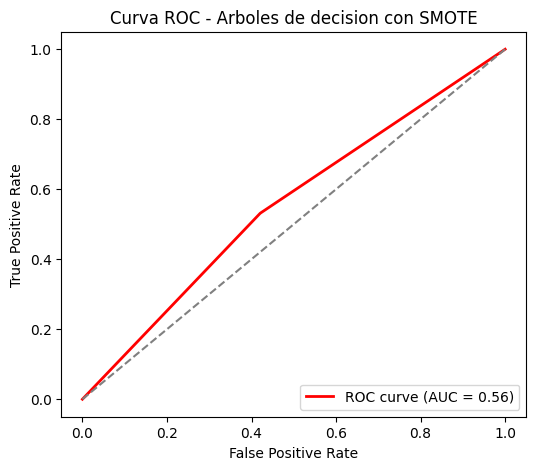

In [15]:
result_con = evaluar_modelo(pipeline_con_smote, X_test, y_test, nombre_modelo="Arboles de decision con SMOTE")

### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **árboles de decisión con SMOTE** muestra que el modelo clasifica correctamente la clase 0 en el **31.25 % de los casos (6,360 observaciones)**, mientras que se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.67 % de los casos (4,613 observaciones)**.

En cuanto a la clase 1, el modelo la clasifica correctamente en el **24.47 % de los casos (4,982 observaciones)**, y se equivoca al predecir la clase 0 cuando en realidad era 1 en el **21.59 % de los casos (4,399 observaciones)**.

Esto evidencia un **rendimiento similar al del modelo sin SMOTE**, aunque con una ligera mejora en la detección de la clase 1. Sin embargo, los errores siguen siendo relativamente equilibrados entre ambas clases, lo que indica que el modelo aún presenta dificultades para separar correctamente las clases pese al balanceo aplicado.

---

### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 55.7 % de las predicciones totales, mostrando un rendimiento **moderado**.

**Precision:** El 51.9 % de las predicciones positivas (clase 1) son correctas, lo cual evidencia una presencia de **falsos positivos** moderada.

**Recall:** De todos los casos que realmente eran positivos, el modelo identificó correctamente el 53.1 %. Esto refleja una **ligera mejora** en sensibilidad respecto al modelo sin SMOTE.

**F1-score:** Con un valor de 0.525, el modelo mantiene un desempeño **medio-bajo**, pero más equilibrado entre precisión y recall.

**AUC:** El valor de 0.555 indica una **capacidad limitada para distinguir entre clases**, apenas superior al azar. Esto sugiere que el modelo aún no logra capturar de manera efectiva las diferencias entre los pacientes que reingresan y los que no.

---

### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
| ------------ | ---------- | ------- | -------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| **Clase 0** | 0.59       | 0.58    | 0.59     | El modelo identifica correctamente la clase 0 en un **58 %** de los casos. Mantiene un rendimiento **ligeramente superior** en esta clase, que suele tener más representaciones. |
| **Clase 1** | 0.52       | 0.53    | 0.53     | El modelo logra una **mejor detección** de la clase 1 en comparación con la versión sin SMOTE, aunque todavía confunde una proporción considerable de casos positivos. |

El modelo de árboles de decisión **con SMOTE** presenta un rendimiento **similar al modelo sin balanceo**, pero con una **mejor capacidad para identificar la clase minoritaria (clase 1)**. No obstante, el AUC de 0.56 y la precisión general del 55.7 % reflejan que aún se requiere **ajuste de hiperparámetros** o técnicas de modelado más robustas para mejorar la discriminación entre clases.

---

### **Curva ROC:**

La curva ROC del modelo con SMOTE muestra un AUC de **0.56**, lo que confirma que la capacidad del modelo para distinguir entre pacientes que reingresarán y los que no **sigue siendo baja**. Aunque el balanceo con SMOTE mejora ligeramente la sensibilidad, el modelo continúa con un rendimiento apenas superior al azar, por lo que se recomienda **explorar modelos más complejos o combinaciones de características adicionales** para optimizar la predicción.


## **4.1.3 Arbol de decision con ADASYN**

In [ ]:
modelo = DecisionTreeClassifier( 
    criterion="gini", # también podrías usar 'entropy' o 'log_loss' 
    max_depth=None, # sin límite de profundidad 
    random_state=42 )

pipeline_arbol_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier",modelo )
])

try:
    pipeline_arbol_adasyn.fit(X_train, y_train)
    result_bayes_adasyn = evaluar_modelo(pipeline_arbol_adasyn, X_test, y_test, nombre_modelo="Arboles de decision con ADASYN")
except ValueError as e:
    print(f"⚠️ ADASYN no pudo generar muestras sintéticas: {e}")
    result_arbol_adasyn = {"Modelo": "Arboles de decision con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


⚠️ ADASYN no pudo generar muestras sintéticas: No samples will be generated with the provided ratio settings.


Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [17]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

## **4.1.4 Arbol de decision con class weight=’balanced’**


In [18]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [19]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
modelo_balanceado = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    random_state=42,
    class_weight="balanced"   # <-- clave
)

pipeline_balanceado = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", modelo_balanceado)
])

In [22]:
# Entrenamiento
pipeline_balanceado.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

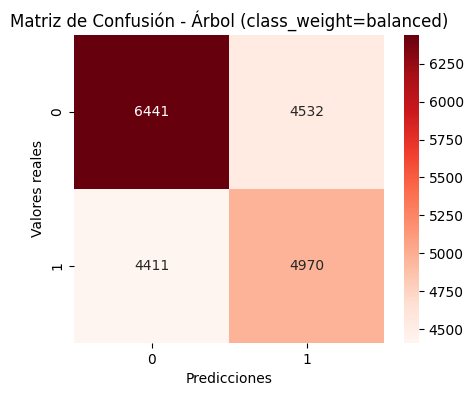

Modelo: Árbol (class_weight=balanced)
Accuracy: 0.561
Precision: 0.523
Recall: 0.53
F1-score: 0.526
AUC: 0.558

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59     10973
           1       0.52      0.53      0.53      9381

    accuracy                           0.56     20354
   macro avg       0.56      0.56      0.56     20354
weighted avg       0.56      0.56      0.56     20354



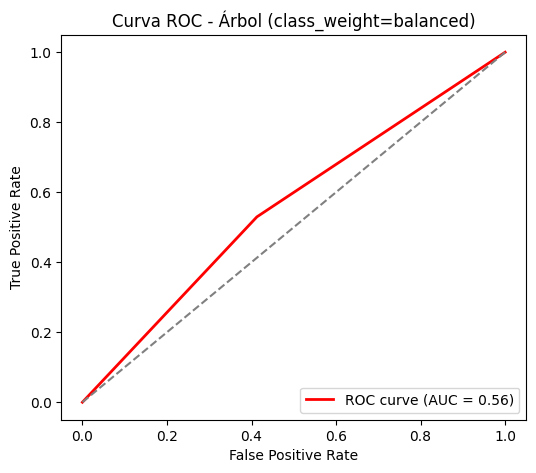

In [23]:
# Evaluación con tu función existente
resultados_classweight = evaluar_modelo(
    pipeline_balanceado, X_test, y_test, nombre_modelo="Árbol (class_weight=balanced)"
)

### **Análisis Matriz de Confusión:**

La matriz de confusión del modelo de **árbol de decisión con `class_weight=balanced`** muestra que el modelo clasifica correctamente la clase 0 en el **31.64 % de los casos (6,441 observaciones)** y se equivoca al asignar la clase 1 cuando en realidad era 0 en el **22.27 % de los casos (4,532 observaciones)**.

Por otro lado, al clasificar la clase 1, el modelo acierta en el **24.42 % de los casos (4,970 observaciones)** y falla en el **21.66 % (4,411 observaciones)**.  
Estos resultados indican que el modelo mejora ligeramente el equilibrio entre clases respecto a la versión sin ponderación, gracias al ajuste de los pesos de las clases, pero aún mantiene una proporción importante de errores en ambas categorías.

---

### **Análisis Métricas:**

**Accuracy:** El modelo acierta en el 56.1 % de las predicciones totales, mostrando un rendimiento moderado.  

**Precision:** De todas las predicciones positivas (clase 1), el 52.3 % fueron realmente positivas, lo cual revela que aún existen falsos positivos en cantidad significativa. 

**Recall:** De todos los casos que realmente eran positivos, el modelo detectó correctamente el 53 %. Esto indica una leve mejora en la sensibilidad respecto al modelo sin balanceo.  

**F1-score:** Con un valor de 0.526, el modelo presenta un rendimiento medio-bajo, aunque algo más equilibrado que el anterior.  

**AUC:** Con 0.558, el modelo mantiene una capacidad muy limitada para diferenciar entre clases, apenas superior al azar (0.5).

---

### **Reporte de Clasificación:**
| Clase       | Precision | Recall | F1-score | Interpretación                                                                                                                                                                       |
|-------------|-----------|--------|----------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Clase 0** | 0.59      | 0.59   | 0.59     | El modelo logra identificar la clase 0 con un **59 %** de efectividad. Muestra un desempeño ligeramente mejor para esta clase, la cual sigue siendo la **mayoritaria**. |
| **Clase 1** | 0.52      | 0.53   | 0.53     | Aunque el balanceo de clases mejora marginalmente el reconocimiento de la clase 1, el modelo aún confunde una cantidad considerable de casos positivos. |

---

### **Conclusión General:**

El modelo de **árbol de decisión con `class_weight=balanced`** presenta un desempeño moderado, con una **accuracy del 56.1 %** y métricas de precisión, recall y F1-score alrededor de 0.52–0.53.  
Si bien el balanceo de clases reduce levemente el sesgo hacia la clase mayoritaria, la capacidad del modelo para distinguir entre pacientes que **reingresarán** y los que **no lo harán** sigue siendo limitada.

---

### **Curva ROC:**

La curva ROC muestra un **AUC de 0.56**, lo que evidencia que el modelo con pesos balanceados **solo mejora marginalmente** la capacidad de discriminación frente a la versión sin balanceo. En términos prácticos, esto significa que el modelo **no logra separar eficazmente** los pacientes que reingresarán de los que no, lo que refuerza la necesidad de aplicar estrategias de optimización adicionales.


## **4.1.5 Comparacion de resultados de tecnicas de balanceo para Arbol de decision**


In [24]:
tabla_resultados = pd.DataFrame([
    result_sin,
    result_con,
    resultados_classweight
])

In [ ]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                          Modelo  Accuracy  Precision    Recall        F1  \
0  Arboles de decision sin SMOTE  0.564852   0.527463  0.536403  0.531896   
1  Arboles de decision con SMOTE  0.557237   0.519229  0.531073  0.525084   
2  Árbol (class_weight=balanced)  0.560627   0.523048  0.529794  0.526399   

        AUC  
0  0.562778  
1  0.555379  
2  0.558417  


### **Conclusión General Comparativa: Modelos de Árboles de Decisión**

En esta comparación entre los tres enfoques del modelo de **árboles de decisión** (sin SMOTE, con SMOTE y con `class_weight=balanced`), el desempeño general es **moderado**, pero existen diferencias relevantes al analizar las métricas más importantes para nuestro caso.

Dado que el objetivo es **predecir si un paciente con diabetes reingresará al hospital**, la **métrica más importante es el *Recall***, ya que **nos interesa identificar la mayor cantidad posible de pacientes que realmente reingresarán**, incluso si eso implica cometer algunos falsos positivos. En un contexto médico, **no detectar a un paciente con alto riesgo de reingreso (falso negativo)** puede tener consecuencias más graves que clasificar erróneamente a alguien como de riesgo cuando no lo es.

### **Análisis de las Métricas Clave:**

| Modelo                            | Accuracy | Precision | Recall | F1-score | AUC  | Interpretación del Recall |
|-----------------------------------|-----------|------------|---------|-----------|------|----------------------------|
| **Árboles de decisión sin SMOTE** | 0.565     | 0.527      | **0.536** | 0.532     | 0.563 | Detecta correctamente el 53.6% de los pacientes que realmente reingresan. |
| **Árboles de decisión con SMOTE** | 0.557     | 0.519      | **0.531** | 0.525     | 0.555 | Mejora levemente el balance de clases, pero no aumenta la detección de casos positivos. |
| **Árbol (class_weight=balanced)** | 0.561     | 0.523      | **0.530** | 0.526     | 0.558 | Logra un equilibrio similar, sin mejoras notables en la sensibilidad. |

### **Interpretación:**

- El **modelo sin SMOTE** obtiene el **mejor Recall (0.536)**, lo que significa que **detecta el mayor número de pacientes que realmente reingresan**.  
- La **implementación de SMOTE** no mejora la sensibilidad del modelo, e incluso reduce ligeramente el desempeño global.  
- El uso de **`class_weight=balanced`** ayuda a equilibrar las clases, pero **no supera en Recall ni en AUC** al modelo base.

### **Conclusión Final:**

El **modelo de Árboles de Decisión sin SMOTE** es el **mejor entre los tres** al presentar el **mayor Recall (0.536)** y un **AUC de 0.563**, lo que indica una ligera superioridad en la capacidad de detectar correctamente a los pacientes que reingresarán al hospital.

Aunque el rendimiento general es limitado (cercano al azar), este modelo es **el más adecuado en un contexto clínico**, donde **la prioridad es minimizar los falsos negativos** y asegurar que la mayoría de los pacientes en riesgo sean identificados para recibir seguimiento o intervención preventiva.